<a href="https://colab.research.google.com/github/calhounpaul/GPT-NeoX-20B-8bit-inference/blob/main/GPT_NeoX_20B_8bit_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

## Section 0

**What's this now?**

"Generative Pre-trained Transformer" (GPT) models are a variety of neural network that attempts to complete a block of text according to a pretrained concept of how text should be completed. For example, a model trained by viewing numerous chat logs would, during inference/generation, attempt to continue a partial conversation that is fed to it as a chat log. Another talent shown by these models is summarization, e.g. if a large block of text is followed by "tl;dr:" a model trained on many online posts will know to generate a "Too long; didn't read:" summary of the preceding text.

There are many classes of GPT-type models, but the biggest one available (for local inference) as of this notebook's creation is GPT-NeoX-20B. However, training it requires compute that most people don't have access to. And even running inference is a challenge as the full weights are larger than any consumer grade GPU's vRAM.

**How the?**

If we're just talking about abstract models somewhere out there, FANG+M all appear to be running one or another version of the 185B-param GPT3 (19x bigger than NeoX-20B). You can poke around with OpenAI's davinci, but it's not downloadable, and inference requires a small team of datacenter techs.

In 2021 a loose network of eccentric personalities and interested parties known as EleutherAI generously released [a free pretrained weights file for NeoX-20B](https://blog.eleuther.ai/announcing-20b/), which is currently [available for download at huggingface's repo](https://huggingface.co/EleutherAI/gpt-neox-20b). To create this file the EleutherAI chaps repeatedly showed the network samples from an ~800GB text dataset known as "The Pile", which contains whatever symbol arrangements the EleutherAI people think are pertinent to the bettering of humanity.

This notebook can run "locally" on a colab pro instance, or actually locally on two rtx3090s with nvlink and >90GB of CPU RAM. It should be easy to modify for bigger setups and harder for smaller ones. There are numerous online tutorials explaining that inference on NeoX-20B **runs great on two 3090s with just one simple trick**. Maybe the bottleneck is just in the sparseness of explored hardware configurations, but there are a lot of people raising issues with those setups. In this case I used facebook's bitsandbytes and huggingface's accelerate modules to shrink the model weights and distribute the inference load according to one's GPU setup.

Reducing the model size (and in the dual 3090 setup, splitting things between gpus) was enough with the hardware described. For those with colab non-pro accounts or otherwise smaller setups, you may have luck using [Microsoft's deepspeed](https://github.com/microsoft/DeepSpeed) or one of [the other huggingface tools](https://huggingface.co/docs/transformers/big_models). However you should realistically expect to see a huge increase in inference time. Just because you can technically run this on an orangePi with 1TB of HDD swap doesn't mean it will finish before you retire.

**Who the?**

Notebook Author: https://github.com/calhounpaul

## Section 1: Prereqs

If docker's your thing, here's what I've been running this in:
```
nvidia-docker run -it \
           --gpus all \
           -p 8888:8888 \
           -v $HOME/neox_docker:/root/neox_docker \
           -v $HOME/.cache:/root/.cache \
           -w /root/neox_docker \
           huggingface/transformers-deepspeed:latest-training
```

But using a deepspeed container is overkill. You'd probably do fine with [huggingface/transformers-pytorch-gpu:latest](https://hub.docker.com/r/huggingface/transformers-pytorch-gpu/tags).

**If you're in colab, you don't need docker (but you do still need a pro instance, for now).**

In [ ]:
!pip install -qq accelerate
!pip install -qq --upgrade transformers
!pip install -qq bitsandbytes
#!pip install truecase unidecode ftfy #useful tools for handling text
!pip install -qq gradio

STORE_AND_RETRIEVE_WEIGHTS = True #explained below

## Section 2: Loading the Model

In [ ]:
IS_COLAB = False
if 'google.colab' in str(get_ipython()):
  IS_COLAB = True

In [ ]:
from transformers import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
import torch
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_and_dispatch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, logging
import os
import argparse
torch.cuda.empty_cache()

This example loads "EleutherAI/gpt-neox-20b" from HF.

Other options include:
*   FrostAura/gpt-neox-20b-fiction-novel-generation
*   larrylawl/gpt-neox-20b-shakespeare
*   KoboldAI/GPT-NeoX-20B-Skein

The first two were fine tuned from the original EleutherAI model. This means they probably don't have much new data in them, rather their output has been constrained by partially loosening and fractionally retraining the last bits of a pretrained model. But the KoboldAI model appears to be trained from scratch with a different dataset.

In [ ]:
model_name = "EleutherAI/gpt-neox-20b"

I've made extensive use of the HF "Auto___" classes for configs and the like in the hopes that this notebook will continue to function for more than a week.

This next part creates a model config according to whatever settings the wonderful folks at HF have most recently decided are best for this model. They seem to know what they're doing, and a lot of these parameters are being tested in a space that's so big+sparse that it starts to look like [folklore](https://www.youtube.com/watch?v=AJwnbSP_rq8&t=926).

In [ ]:
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

The first trick is to use accelerate's init_empty_weights() to figure out how to load the model into the current hardware setup.

In [ ]:
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

Then we can specify what needs to go where, what can/can't be optimized, and what datatype we'll eventually use. This results in an efficient device map that we can plug into the pretrained model when it's instantiated next.

In [ ]:
device_map = infer_auto_device_map(model,
                                  max_memory={0: "34GiB", "cpu": "80GiB"} if IS_COLAB else {0: "19GiB",1: "19GiB", "cpu": "90GiB"},
                                  no_split_module_classes=["GPTNeoXLayer"],
                                  dtype=torch.int8
                              )

And now to put it all together **(warning: this next bit takes about 10 minutes at HF-to-colab's respectable 85MB/s)**:


If you're in Colab and you don't want to have to re-download+process 80+GB of weights every time you load this model, you may be able to store them in a storage upgraded Google Drive.

In [ ]:
import shutil

STORE_AND_RETRIEVE_WEIGHTS = False

local_hf_weights_folder = "/root/.cache/huggingface"
remote_gdrive_base = "/content/drive/MyDrive"
remote_weights_folder = remote_gdrive_base + "/huggingface_cache"

def get_folder_size(folder_path):
  size = 0
  for path, dirs, files in os.walk(folder_path):
    for f in files:
      fp = os.path.join(path, f)
      size += os.path.getsize(fp)
  return size

if IS_COLAB and STORE_AND_RETRIEVE_WEIGHTS:
  from google.colab import drive
  drive_path = "/".join(remote_gdrive_base.split("/")[:-1])
  drive.mount(drive_path)  
  if os.path.exists(remote_weights_folder):
    if os.path.exists(local_hf_weights_folder):
      remote_size = get_folder_size(remote_weights_folder)
      local_size = get_folder_size(local_hf_weights_folder)
      if local_size < remote_size +10000:
        os.rmdir(local_hf_weights_folder)
        shutil.copytree(remote_weights_folder,local_hf_weights_folder)
    else:
      shutil.copytree(remote_weights_folder,local_hf_weights_folder)
  else:
    print("not yet backed up, making copy next, after initial download, maybe")

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
                                  model_name,
                                  device_map=device_map,
                                  config=config,
                                  load_in_8bit=True
                              )

In [ ]:
if IS_COLAB and STORE_AND_RETRIEVE_WEIGHTS:  
  if not os.path.exists(remote_weights_folder):
    import pathlib
    pathlib.Path(remote_weights_folder).parent.mkdir(parents=True, exist_ok=True)
    shutil.move(local_hf_weights_folder,remote_weights_folder)
    shutil.copytree(remote_weights_folder,local_hf_weights_folder)
    print("backed up for the first time, assuming this works")

## Section 3: Messing Around

Now to do some few-shot inference.

Here's a template for a simple Q&A:
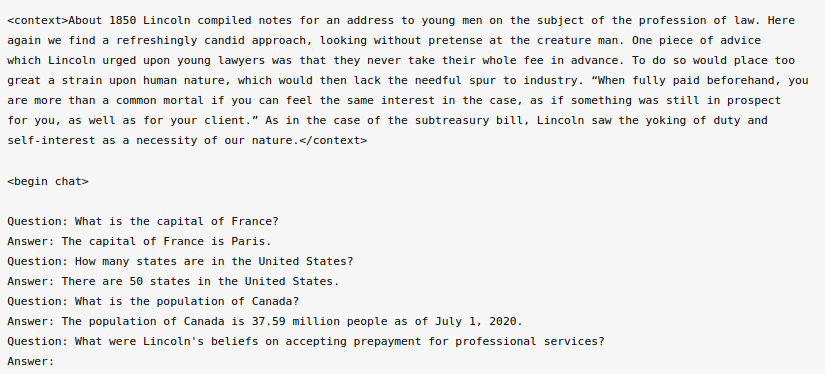


What this arrangement seems to do is force the model to text complete in a way that answers the latest question when given the preceding context. None of the tag formats were intentionally added for training. The model **figures them out from the context and then it follows along**. This is the sort of magic that probably led you to this repo.

In [ ]:
query_in = "<context>About 1850 Lincoln compiled notes for an address to young men on the subject of the profession of law. Here again we find a refreshingly candid approach, looking without pretense at the creature man. One piece of advice which Lincoln urged upon young lawyers was that they never take their whole fee in advance. To do so would place too great a strain upon human nature, which would then lack the needful spur to industry. “When fully paid beforehand, you are more than a common mortal if you can feel the same interest in the case, as if something was still in prospect for you, as well as for your client.” As in the case of the subtreasury bill, Lincoln saw the yoking of duty and self-interest as a necessity of our nature.</context>\n\n<begin chat>\n\nQuestion: What is the capital of France?\nAnswer: The capital of France is Paris.\nQuestion: How many states are in the United States?\nAnswer: There are 50 states in the United States.\nQuestion: What is the population of Canada?\nAnswer: The population of Canada is 37.59 million people as of July 1, 2020.\nQuestion: What were Lincoln's beliefs on accepting prepayment for professional services?\nAnswer:"

In [ ]:
input_ids = tokenizer(query_in, return_tensors="pt").input_ids
input_token_length=input_ids.shape[1]
input_ids = input_ids.to('cuda')
output_tokens = model.generate(
        input_ids,
        do_sample=True,
        temperature=0.9,
        max_length=input_token_length+256,
    )
output_text = tokenizer.batch_decode(output_tokens)[0]
print(output_text)

I have no idea what was generated just now by your use of the above code, but if it's something terrible please send all complaints to the EleutherAI folks, or maybe to HuggingFace, or you can put the model on an SD card and yell at that.

Some of the raw "Answer:" completions I've generated in the past few minutes are:

* *Lincoln recommended that lawyers don’t accept bills in advance as payment for legal work.*

*  *Lincoln stated that accepting prepayment for professional services was a poor business practice.*

*  *Lincoln believed that taking “all your fee in advance” would place too much of a strain on human nature, and result in “not the same interest in the case.”*

*  *Lincoln advised young lawyers to never take a full fee in advance.*

*  *Lincolns advice to young lawyers to not take their fee in advance, to avoid the strain of taking a fee and the lack of needful incentive to the lawyer to work diligently for the clients cause.*

You'll notice much of the output you get is unnecessary (the above examples are truncated after the answer).

The following class allows you to add custom halt tokens. However, you may want to take a look at [how tokenization works under the hood](https://huggingface.co/docs/transformers/main_classes/tokenizer) before you start adding special cases.

A simpler technique to get e.g. a chatbot to halt after generating one response is to add one or two "<|endoftext|>" tokens after each bot response in the preprompt. This should usually few-shot "train" the model to add its own stop character after one reply (as opposed to continuing along and generating the human part of the chat, which can be amusing but is usually unhelpful).

In [ ]:
from transformers import StoppingCriteria
#modified from the EndOfFunctionCriteria class I found somewhere around here: https://huggingface.co/transformers/v4.6.0/_modules/transformers/generation_stopping_criteria.html
class EndOfQuestionCriteria(StoppingCriteria):
  def __init__(self, start_length, eof_strings, tokenizer):
    self.start_length = start_length
    self.eof_strings = eof_strings
    self.tokenizer = tokenizer
  def __call__(self, input_ids, scores, **kwargs):
    decoded_generations = self.tokenizer.batch_decode(input_ids[:, self.start_length :])
    done = []
    for decoded_generation in decoded_generations:
      done.append(any([stop_string in decoded_generation for stop_string in self.eof_strings]))
    return all(done)

Then add the new stop criteria when calling model.generate()

In [ ]:
from transformers import StoppingCriteriaList

extra_eos = ["Human:","AI:","Question:","Answer:","</"]

input_ids = tokenizer(query_in, return_tensors="pt").input_ids
input_token_length=input_ids.shape[1]
input_ids = input_ids.to('cuda')
output_tokens = model.generate(
    input_ids,
    stopping_criteria=StoppingCriteriaList([EndOfQuestionCriteria(
            input_token_length,
            extra_eos,
            tokenizer,
        ),]),
    do_sample=True,
    temperature=0.9,
    max_length=input_token_length+256,
)
output_text = tokenizer.batch_decode(output_tokens)[0]

for eos_str in extra_eos:
  if output_text.endswith(eos_str):
    output_text = output_text[:-len(eos_str)].rstrip()
    break

print(output_text)

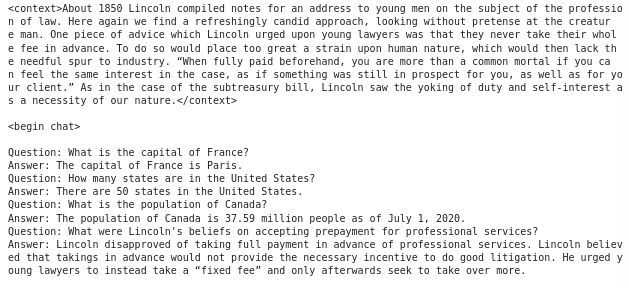

Now seems a good time to hide the magic bits in a function:

In [ ]:
def neox_query(
      query_in,
      extra_eos=["Human:","AI:","Question:","Answer:","</","\n"],
      tmpt=0.95,
    ):
  input_ids = tokenizer(query_in, return_tensors="pt").input_ids
  input_token_length=input_ids.shape[1]
  input_ids = input_ids.to('cuda')
  output_tokens = model.generate(
    input_ids,
    stopping_criteria=StoppingCriteriaList([EndOfQuestionCriteria(
        input_token_length,
        extra_eos,
        tokenizer,
      ),]),
    do_sample=True,
    temperature=tmpt,
    max_length=input_token_length+256,
  )
  output_text = tokenizer.batch_decode(output_tokens)[0]
  for eos_str in extra_eos:
    if output_text.endswith(eos_str):
      output_text = output_text[:-len(eos_str)].rstrip()
      break
  return output_text

# Temperature

For GPT-type models, temperature is loosely defined as "typicality of (per-token) output". This may sound like a simple measure of the overall output's typicality (i.e. the whole output string), but because the typicality constraint is applied on a per-token basis it can have counterintuitive results. For example, a specific starting/early token may be very improbable (e.g. a rare name starting with a non-ascii letter) yet everything that follows may be subsequently recalculated as far more probable than if the improbable start token had never been produced. If this alternative phrase has a higher probability than all the possibilities that don't start with the improbable token, it will still be missed by an "eager" generation strategy that naively chooses only the most probable next token.

There are [methods to generate token sequences that account for these edge cases](https://www.youtube.com/watch?v=_EDr3ryrT_Y), and I intend to implement them here eventually.



## Sentiment Analysis

This model does decent few-shot sentiment analysis.

Here's the preprompt template we'll be using:

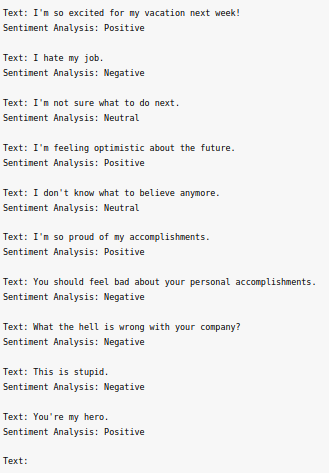

In [ ]:
def analyze_single_sentiment(string_to_analyze):
    prompt = "Text: I'm so excited for my vacation next week!\nSentiment Analysis: Positive\n\nText: I hate my job.\nSentiment Analysis: Negative\n\nText: I'm not sure what to do next. \nSentiment Analysis: Neutral\n\nText: I'm feeling optimistic about the future.\nSentiment Analysis: Positive\n\nText: I don't know what to believe anymore.\nSentiment Analysis: Neutral\n\nText: I'm so proud of my accomplishments.\nSentiment Analysis: Positive\n\nText: You should feel bad about your personal accomplishments.\nSentiment Analysis: Negative\n\nText: What the hell is wrong with your company?\nSentiment Analysis: Negative\n\nText: This is stupid.\nSentiment Analysis: Negative\n\nText: You're my hero.\nSentiment Analysis: Positive\n\nText: " + string_to_analyze + "\nSentiment Analysis:"
    sentiment_eos_stop_sequences = ["Text:","Sentiment Analysis:","\n"]
    return_val = neox_query(prompt,sentiment_eos_stop_sequences)[len(prompt):]
    for ssq in sentiment_eos_stop_sequences:
        if return_val.endswith(ssq):
            return_val = return_val[:-len(ssq)]
    return return_val.strip()

In [ ]:
analyze_single_sentiment("Steve Buscemi is a class act.")

This is already pretty accurate (the above inference example typically returns positive sentiment, which I'll assume is because Steve Buscemi is indeed a class act) but if we'd prefer accuracy over speed we can clean up the results a bit by averaging samples.

In [ ]:
def average_sentiment(string_to_analyze, analyses=12):
    score = 0
    for num in range(analyses):
        value = analyze_single_sentiment(string_to_analyze)
        if "negative" in value.lower():
            score -= 1
        elif "positive" in value.lower():
            score += 1
    if score >2:
        return "positive"
    elif score < -2:
        return "negative"
    return "neutral"

In [ ]:
average_sentiment("My son HW will be president one day.")

Some results:

*   Isaac Newton was kind of a jerk: Negative
*   My son HW will be president one day: Positive
*   Hell is other people: Negative
*   I just don't know what to think: Neutral